# Self-Supervised Voice Emotion Recognition

In this project I build a self-supervised binary emotion classifier from speech audio. Emotions are complex multidimensional concepts, but in this project, given an audio clip the model predicts whether the emotion of the voice is positive or negative. 

In [2]:
# Imports necessary libraries
import os
from glob import glob as gg
import numpy as np
from scipy.io import wavfile
from scipy.signal import resample
import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import librosa
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D,
                         MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import swifter

In [3]:
# Loads all transcripts into a dataframe, raw MOSEI data can be found at
# http://immortal.multicomp.cs.cmu.edu/raw_datasets/CMU_MOSEI.zip
transcripts = pd.DataFrame()
transcript_cols = ["id", "num", "start", "end", "text"]
for f in gg("data/transcripts/*.txt"):
    try:
        tmp = pd.read_csv(f,
                          names=transcript_cols,
                          sep="___",
                          engine="python",
                          dtype={
                              "id": str,
                              "num": int,
                              "start": float,
                              "end": float,
                              "text": str
                          })
        transcripts = pd.concat([transcripts, tmp], axis=0, ignore_index=True)
    except:
        pass

In [4]:
# Prints five random rows
transcripts.sample(5)

,id,num,start,end,text
35101,kRs39SO-neY,15,64.734000,73.207000,If you even meet a challenging participant wit...
23550,221104,7,30.293000,36.331000,(uhh) It is a comedy about (uhh) relationship...
16650,oj7A8mpuBeQ,11,41.088000,50.309000,It turns out that pitches that rhyme are often...
23787,254216,8,37.716000,50.299000,"And it's it's (stutter) a really, it's really..."
26779,9Lr4i7bIB6w,3,35.831066,43.433787,Here is where you will learn more about NASA...


In [6]:
# Calculates duration of the utterances
transcripts["duration"] = transcripts["end"] - transcripts["start"]

Mean = 7.36, std = 5.48


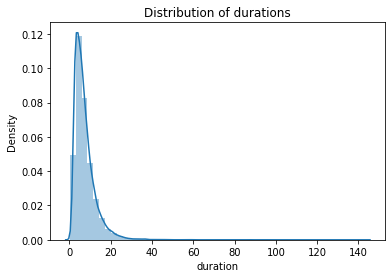

In [7]:
# Plots the distribution of durations
sns.distplot(transcripts["duration"]).set(title="Distribution of durations");
print("Mean = {0:.2f}, std = {1:.2f}".format(transcripts["duration"].mean(),transcripts["duration"].std()))

In [8]:
# Computes the sentiments using Vader
analyser = SentimentIntensityAnalyzer()
transcripts["vader_sentiment"] = transcripts["text"].apply(lambda x: analyser.polarity_scores(x)["compound"])

In [9]:
# Computes the sentiments using TextBlob
transcripts["textblob_sentiment"] = transcripts["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [10]:
# Computes the average sentiment
transcripts["avg_sentiment"] = transcripts[["vader_sentiment", "textblob_sentiment"]].mean(axis=1)

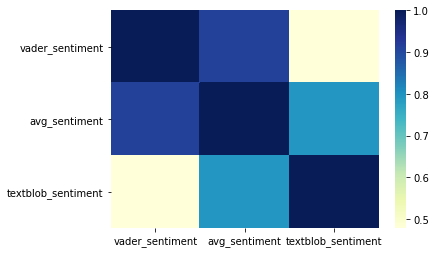

In [12]:
# Plots the correlations between sentiment scores
sns.heatmap(transcripts[["vader_sentiment", "avg_sentiment", "textblob_sentiment"]].corr(), cmap="YlGnBu");

In [14]:
# Prints the correlations between sentiment scores
transcripts[["vader_sentiment", "avg_sentiment", "textblob_sentiment"]].corr()

,vader_sentiment,avg_sentiment,textblob_sentiment
vader_sentiment,1.000000,0.914118,0.479080
avg_sentiment,0.914118,1.000000,0.793826
textblob_sentiment,0.479080,0.793826,1.000000


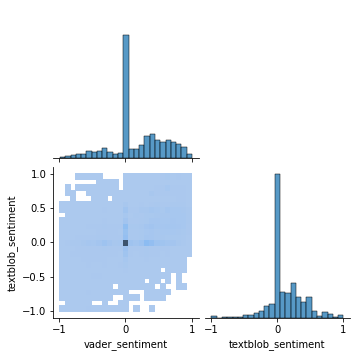

In [16]:
# Plots the joint distributions of sentiment scores
g = sns.pairplot(transcripts[["vader_sentiment","textblob_sentiment"]],
                 kind="hist",
                 diag_kind="hist",
                 corner=True,
                 plot_kws={"bins":25},
                 diag_kws={"bins":25})

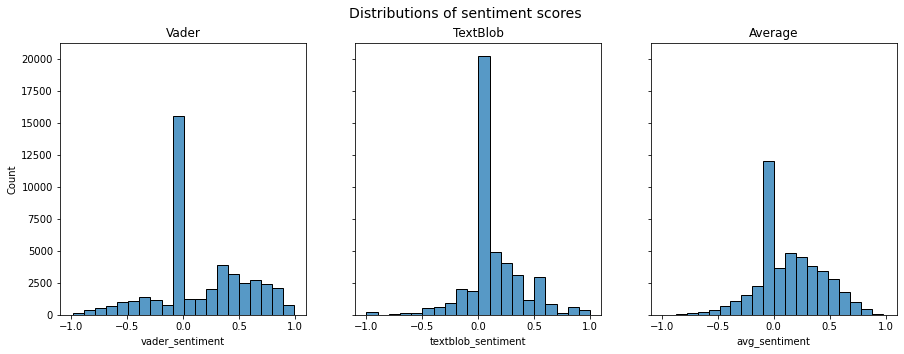

In [17]:
# Plots the distributions of sentiment scores
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15,5))
fig.suptitle("Distributions of sentiment scores", size=14)
sns.histplot(transcripts["vader_sentiment"], bins=20, ax=axes[0])
axes[0].set_title("Vader")
sns.histplot(transcripts["textblob_sentiment"], bins=20, ax=axes[1])
axes[1].set_title("TextBlob")
sns.histplot(transcripts["avg_sentiment"], bins=20, ax=axes[2])
axes[2].set_title("Average")
fig;

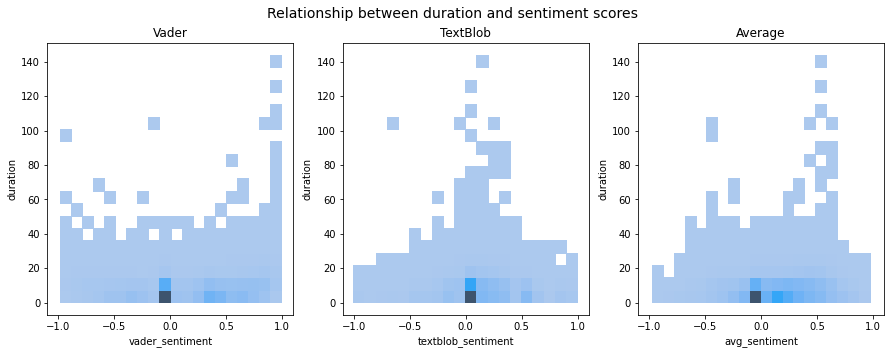

In [18]:
# Plots the relationship between duration and sentiment scores
fig, axes = plt.subplots(1, 3, sharey=False, sharex=True, figsize=(15,5))
fig.suptitle("Relationship between duration and sentiment scores", size=14)
sns.histplot(data=transcripts, x="vader_sentiment", y="duration", bins=20, ax=axes[0])
axes[0].set_title("Vader")
sns.histplot(data=transcripts, x="textblob_sentiment", y="duration", bins=20, ax=axes[1])
axes[1].set_title("TextBlob")
sns.histplot(data=transcripts, x="avg_sentiment", y="duration", bins=20, ax=axes[2])
axes[2].set_title("Average")
fig;

In [19]:
# Processes audio files, raw MOSEI data can be found at
# http://immortal.multicomp.cs.cmu.edu/raw_datasets/CMU_MOSEI.zip

# Creates a folder to store split audio files
if not os.path.exists("data/audio_split/"):
    os.makedirs("data/audio_split/")
# Creates a wav_file column to store the file names of split audio files
transcripts["wav_file"] = ""
# Loops over all original audio files
for f in gg("data/audio/*.wav"):
    # Extracts the id from the file name
    file_id = os.path.basename(f).split(".")[0] 
    # Checks if the file id is in the transcripts dataframe
    if file_id in transcripts["id"].values:
        # Reads the audio file
        rate, data = wavfile.read(f)
        # Loops over all rows in the transcripts dataframe that correspond to this id
        for _, row in transcripts.loc[transcripts["id"]==file_id, ["id","num","start","end"]].iterrows():
            # Extracts the clip from the file based on start and end timestamps
            clip = data[int(row["start"]*rate):int(row["end"]*rate)+1]
            # Generates the file name for the new split audio clip
            new_f = "data/audio_split/"+file_id+"_"+str(row["num"])+".wav"
            # Saves the audio clip
            wavfile.write(new_f, rate, clip)
            # Adds the new file name to the wav_file column of the transcripts dataframe
            transcripts.loc[row.name, "wav_file"] = new_f

In [20]:
def crop_or_pad_audio(file_name, target_sec=7, target_rate=16000):
    """Crops or pads audio files to a desired length and target rate

        Args:
            file_name (str): File name of the WAV file
            target_sec (int): Target length in seconds
            target_rate (int): Target rate per second

        Returns:
            str: File name of the new WAV file
    """
    # Calculates target length
    target_len = target_sec * target_rate
    rate, data = wavfile.read(file_name)
    # Resamples the audio to the target rate
    if rate != target_rate:
        resampled_n = int(len(data) / rate * target_rate)
        data = resample(data, resampled_n)
    # Crops or Pads the wav file to the target length
    if len(data) > target_len:
        # Randomly chooses an offset
        max_offset = len(data)-target_len
        offset = np.random.randint(max_offset)
        # Crops the audio
        data = data[offset:(target_len+offset)]
    else:
        # Randomly chooses an offset
        max_offset = target_len - len(data)
        offset = np.random.randint(max_offset) if max_offset > 0 else 0
        # Pads the audio with 0s
        data = np.pad(data, (offset, target_len - len(data) - offset), "constant")
    # Generates the file name for the new fixed length audio clip
    new_f = file_name.replace("audio_split","audio_fixed")
    # Saves the audio clip
    wavfile.write(new_f, target_rate, data)
    # Returns the new file name
    return new_f

In [21]:
# Creates a folder to store fixed length split audio files
if not os.path.exists("data/audio_fixed/"):
    os.makedirs("data/audio_fixed/")
# Crops or Pads all audio files in the DataFrame to a fixed length
transcripts["wav_file_fixed"] = transcripts["wav_file"].apply(crop_or_pad_audio)

In [26]:
def mel_spectogram_db(file_name, mels=60):
    """Returns the mel spectrogram for a given audio file and mel count

        Args:
            file_name (str): File name of the WAV file
            mels (int): Target length in seconds

        Returns:
            numpy.ndarray: Numpy array of mel spectrogram values
    """
    data, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    mel_spectogram = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=mels)
    mel_db = librosa.power_to_db(mel_spectogram, ref=np.max)
    return mel_db.T

In [ ]:
# Computes the MEL Spectogram DB for each fixed length split audio file
transcripts["mel_spectogram_db"] = transcripts["wav_file_fixed"].swifter.apply(mel_spectogram_db)

In [28]:
# Computes the mean for each mel
transcripts["mel_spectogram_db_mean"] = transcripts["mel_spectogram_db"].apply(np.mean, axis=0)

In [29]:
# Creates classes (excludes examples with very low sentiment)
threshold = 0.2
pred_col_name = "vader_sentiment"
transcripts.loc[transcripts[pred_col_name]<-threshold, "Positive"] = 0
transcripts.loc[transcripts[pred_col_name]>=threshold, "Positive"] = 1
transcripts.dropna(inplace=True)

In [30]:
# Creates a column for train/valid/test split of the dataset
np.random.seed(42)
rand_unif = np.random.uniform(0, 1, transcripts.shape[0])
transcripts["set"] = "test"
transcripts.loc[rand_unif<0.9, "set"] = "val"
transcripts.loc[rand_unif<0.8, "set"] = "train"

In [31]:
# Creates the X for train, val and test sets
X_train = np.stack(transcripts.loc[transcripts["set"]=="train", "mel_spectogram_db_mean"])
X_val = np.stack(transcripts.loc[transcripts["set"]=="val", "mel_spectogram_db_mean"])
X_test = np.stack(transcripts.loc[transcripts["set"]=="test", "mel_spectogram_db_mean"])

In [33]:
# Creates the 2D X for train, val and test sets
X_train_full = np.stack(transcripts.loc[transcripts["set"]=="train", "mel_spectogram_db"])
X_val_full = np.stack(transcripts.loc[transcripts["set"]=="val", "mel_spectogram_db"])
X_test_full = np.stack(transcripts.loc[transcripts["set"]=="test", "mel_spectogram_db"])

In [34]:
# Creates the y for train, val and test sets
y_col = "Positive"
y_train = transcripts.loc[transcripts["set"]=="train", y_col].to_numpy()
y_val = transcripts.loc[transcripts["set"]=="val", y_col].to_numpy()
y_test = transcripts.loc[transcripts["set"]=="test", y_col].to_numpy()

In [35]:
# Scales the X sets
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

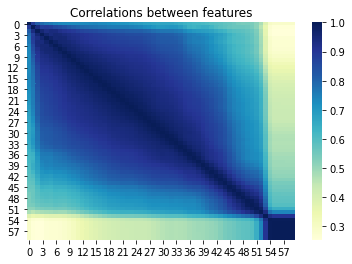

In [36]:
# Plots the correlations between features
sns.heatmap(pd.DataFrame(X_train).corr(), cmap="YlGnBu").set(title="Correlations between features");

In [37]:
# Creates PCA X for train, val and test sets
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [40]:
def prediction_plot(y_true, y_pred, title, subset):
    """Plots the ROC curve for the given predictions

        Args:
            y_true (numpy.ndarray): Actual y values
            y_pred (numpy.ndarray): Predicted y values
            title (str): Title of the plot
            subset (str): Subtitle of the plot

        Returns:
            None
    """
    # Generates FPR and TPR for the ROC curve
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, marker=".", label="AUC = %0.2f" % roc_auc, zorder=0)
    plt.plot([0,1], [0,1], linestyle="--", label="No Skill", zorder=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.suptitle(title, y=1.005, fontsize=14)
    plt.title(subset, fontsize=12)
    plt.legend()
    plt.show()
    return

## Baseline Model: Random Guess

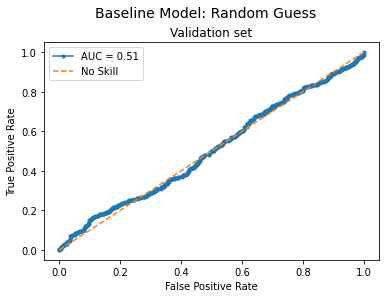

In [41]:
# Baseline Model: Random Guess
predictions = np.random.uniform(0,1,len(y_val))
prediction_plot(y_val, predictions, "Baseline Model: Random Guess", "Validation set")

## Baseline Model: Majority Class

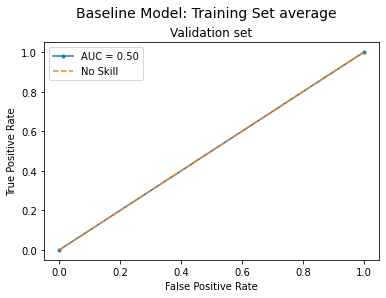

In [44]:
# Baseline Model: Majority Class
predictions = np.full(len(y_val), scipy.stats.mode(y_train)[0][0])
prediction_plot(y_val, predictions, "Baseline Model: Training Set average", "Validation set")

## Random Forest Classifier

In [45]:
# Trains a Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0, n_jobs=3)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=3, random_state=0)

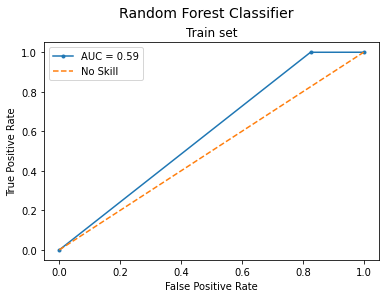

In [46]:
predictions = rf_clf.predict(X_train)
prediction_plot(y_train, predictions, "Random Forest Classifier", "Train set")

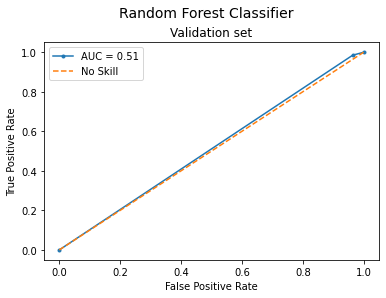

In [47]:
predictions = rf_clf.predict(X_val)
prediction_plot(y_val, predictions, "Random Forest Classifier", "Validation set")

## Random Forest Classifier (PCA)

In [48]:
# Trains a Random Forest Classifier
rf_clf_pca = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0, n_jobs=3)
rf_clf_pca.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=3, random_state=0)

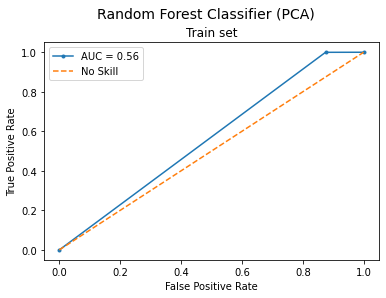

In [49]:
predictions = rf_clf_pca.predict(X_train_pca)
prediction_plot(y_train, predictions, "Random Forest Classifier (PCA)", "Train set")

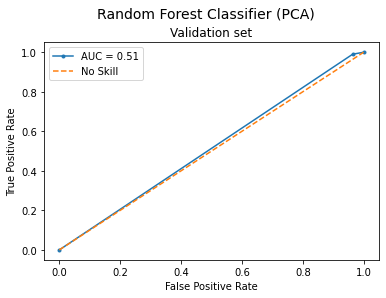

In [50]:
predictions = rf_clf_pca.predict(X_val_pca)
prediction_plot(y_val, predictions, "Random Forest Classifier (PCA)", "Validation set")

## KNN Classifier

In [52]:
# Creates a KNN Classifier
knn_clf = KNeighborsClassifier(n_neighbors=10)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

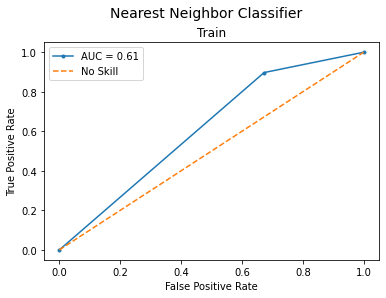

In [53]:
predictions = knn_clf.predict(X_train)
prediction_plot(y_train, predictions, "Nearest Neighbor Classifier", "Train")

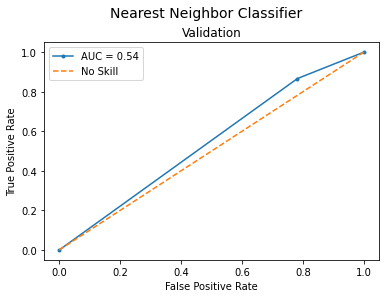

In [54]:
predictions = knn_clf.predict(X_val)
prediction_plot(y_val, predictions, "Nearest Neighbor Classifier", "Validation")

## Neural Network

In [55]:
# Creates a DNN Classifier
model = Sequential()
input_size = len(X_train[0])
model.add(Dense(30, input_shape=(input_size,), activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(30, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(20, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(5, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(5, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam")

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0

In [57]:
logs = model.fit(X_train, y_train, batch_size=32, epochs=100, 
                 validation_data=(X_val, y_val))

Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 0.6306 - val_loss: 0.6065
Epoch 2/100
350/350 [==============================] - 0s 1ms/step - loss: 0.5965 - val_loss: 0.6033
Epoch 3/100
350/350 [==============================] - 0s 1ms/step - loss: 0.6015 - val_loss: 0.6035
Epoch 4/100
350/350 [==============================] - 0s 1ms/step - loss: 0.5929 - val_loss: 0.6024
Epoch 5/100
350/350 [==============================] - 0s 1ms/step - loss: 0.5961 - val_loss: 0.6007
Epoch 6/100
350/350 [==============================] - 0s 1ms/step - loss: 0.5959 - val_loss: 0.6010
Epoch 7/100
350/350 [==============================] - 0s 1ms/step - loss: 0.5929 - val_loss: 0.6011
Epoch 8/100
350/350 [==============================] - 0s 1ms/step - loss: 0.5886 - val_loss: 0.6005
Epoch 9/100
350/350 [==============================] - 0s 1ms/step - loss: 0.5914 - val_loss: 0.5999
Epoch 10/100
350/350 [==============================] - 0s 1ms/step - loss: 0.5847 - val_lo

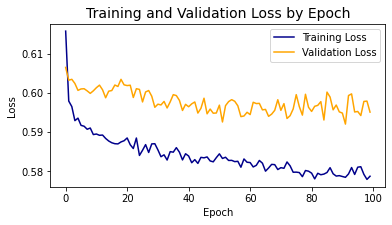

In [58]:
# Training and Validation loss by epoch
train_loss = logs.history["loss"]
val_loss = logs.history["val_loss"]
plt.figure(figsize=(6, 3))
plt.plot(train_loss, label="Training Loss", color="darkblue")
plt.plot(val_loss, label="Validation Loss", color="orange")
plt.title("Training and Validation Loss by Epoch", fontsize = 14)
plt.xlabel("Epoch", fontsize = 10)
plt.ylabel("Loss", fontsize = 10)
plt.legend(fontsize = 10);

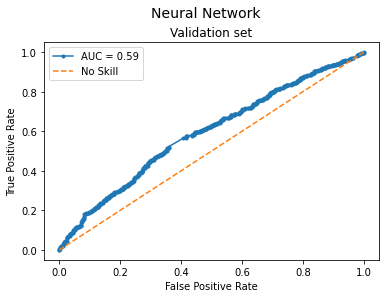

In [59]:
predictions = np.hstack(model.predict(X_val))
prediction_plot(y_val, predictions, "Neural Network", "Validation set")

## Neural Network (VGG Feature Extraction)

In [61]:
# Preprocesses inputs for the VGG model
X_train_img = preprocess_input(np.repeat(((X_train_full.reshape(*X_train_full.shape, 1) + 80) / 80 * 100), 3, axis=3))
X_val_img = preprocess_input(np.repeat(((X_val_full.reshape(*X_val_full.shape, 1) + 80) / 80 * 100), 3, axis=3))
X_test_img = preprocess_input(np.repeat(((X_test_full.reshape(*X_test_full.shape, 1) + 80) / 80 * 100), 3, axis=3))

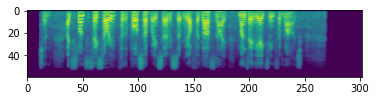

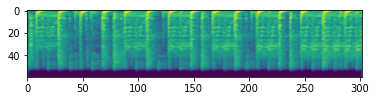

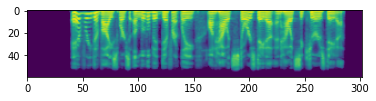

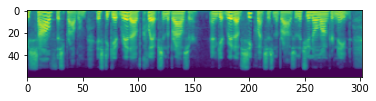

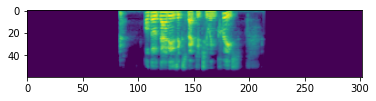

In [63]:
# Plots 5 random spectrograms
for _ in range(5):
    plt.imshow(X_train_img[np.random.choice(X_train_img.shape[0])].swapaxes(1,0)[:,:,0])
    plt.show()

In [64]:
# Loads the VGG16 model
vgg = VGG16(weights="imagenet", include_top=False, pooling="avg", input_shape=X_train_img.shape[1:])

# Selects the layer from which to get the outputs
vgg_layer = "block3_conv3"
vgg_block = Model(inputs=vgg.input, outputs=vgg.get_layer(vgg_layer).output)

# Extracts features for train, val and test sets
X_train_vgg = vgg_block.predict(X_train_img)
X_val_vgg = vgg_block.predict(X_val_img)
X_test_vgg = vgg_block.predict(X_test_img)

In [68]:
# Prints the layers that have been used for feature extraction
vgg_block.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 302, 60, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 302, 60, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 302, 60, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 151, 30, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 151, 30, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 151, 30, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 15, 128)       0     

In [70]:
# Creates a DNN Classifier from VGG16 extracted features
model_vgg = Sequential()

model_vgg.add(GlobalAveragePooling2D( input_shape=X_train_vgg.shape[1:]))
model_vgg.add(Dense(10))
model_vgg.add(Dropout(0.25))
model_vgg.add(Dense(10))
model_vgg.add(Dropout(0.25))
model_vgg.add(Dense(10))
model_vgg.add(Dropout(0.25))

model_vgg.add(Dense(1, activation = "sigmoid"))
model_vgg.compile(loss="binary_crossentropy", optimizer="adam")

In [71]:
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2570      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)               

In [72]:
logs = model_vgg.fit(X_train_vgg, y_train, batch_size=8, epochs=20, validation_data=(X_val_vgg, y_val))

Epoch 1/20
1398/1398 [==============================] - 22s 15ms/step - loss: 35.0871 - val_loss: 1.0257
Epoch 2/20
1398/1398 [==============================] - 23s 16ms/step - loss: 2.8936 - val_loss: 0.6468
Epoch 3/20
1398/1398 [==============================] - 34s 25ms/step - loss: 0.9617 - val_loss: 0.6098
Epoch 4/20
1398/1398 [==============================] - 41s 30ms/step - loss: 0.6567 - val_loss: 0.6050
Epoch 5/20
1398/1398 [==============================] - 22s 15ms/step - loss: 0.6030 - val_loss: 0.5986
Epoch 6/20
1398/1398 [==============================] - 45s 32ms/step - loss: 0.5941 - val_loss: 0.6017
Epoch 7/20
1398/1398 [==============================] - 20s 14ms/step - loss: 0.6029 - val_loss: 0.5981
Epoch 8/20
1398/1398 [==============================] - 21s 15ms/step - loss: 0.6002 - val_loss: 0.5987
Epoch 9/20
1398/1398 [==============================] - 28s 20ms/step - loss: 0.6010 - val_loss: 0.5979
Epoch 10/20
1398/1398 [==============================] - 25s 18

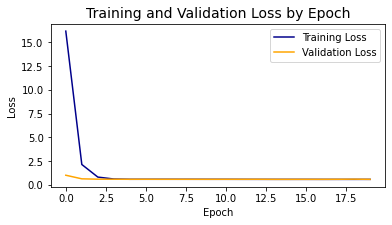

In [74]:
# Training and Validation loss by epoch
train_loss = logs.history["loss"]
val_loss = logs.history["val_loss"]
plt.figure(figsize=(6, 3))
plt.plot(train_loss, label="Training Loss", color="darkblue")
plt.plot(val_loss, label="Validation Loss", color="orange")
plt.title("Training and Validation Loss by Epoch", fontsize = 14)
plt.xlabel("Epoch", fontsize = 10)
plt.ylabel("Loss", fontsize = 10)
# plt.yscale("log")
plt.legend(fontsize = 10);

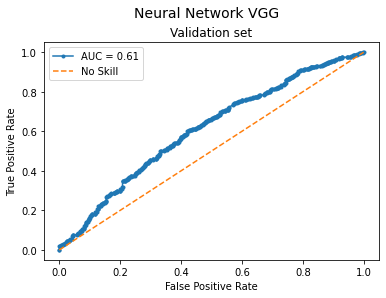

In [76]:
predictions = np.hstack(model_vgg.predict(X_val_vgg))
prediction_plot(y_val, predictions, "Neural Network VGG", "Validation set")

## Performance on Test set

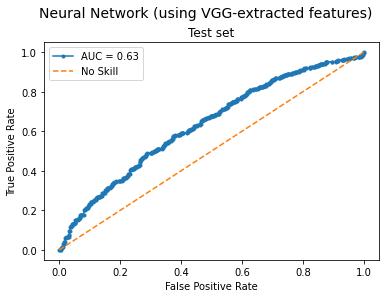

In [77]:
predictions = np.hstack(model_vgg.predict(X_test_vgg))
prediction_plot(y_test, predictions, "Neural Network (using VGG-extracted features)", "Test set")